# Bitcoin Price Prediction Using Machine Learning
Nhập môn Học máy và Khai phá dữ liệu (IT3190)

## 1. Import Libraries

In [5]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import math

# Machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# ML Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

# Deep learning
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time series
import datetime as dt

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'numpy'

## 2. Data Loading and Exploration

In [26]:
# Tải dữ liệu
print("Đang tải dữ liệu lịch sử Bitcoin...")

# Đường dẫn đến tệp dữ liệu
duong_dan = '/kaggle/input/bitcoin-historical-data/btcusd_1-min_data.csv'

# Đọc dữ liệu từ tệp CSV
df = pd.read_csv(duong_dan)

# Hiển thị thông tin cơ bản
print("\nThông tin về tập dữ liệu:")
print(f"Kích thước tập dữ liệu: {df.shape}")

print("\nKiểu dữ liệu của các cột:")
print(df.dtypes)


Loading Bitcoin historical data...

Dataset Information:
Dataset shape: (6780281, 6)

Data Types:
Timestamp    float64
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
dtype: object


In [27]:
# Chuyển đổi cột timestamp sang dạng datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# Đặt timestamp làm chỉ mục
df.set_index('Timestamp', inplace=True)

# Hiển thị 5 dòng đầu tiên của tập dữ liệu
print("\n5 dòng đầu tiên của tập dữ liệu:")
print(df.head())



First 5 rows of the dataset:
                     Open  High   Low  Close  Volume
Timestamp                                           
2012-01-01 10:01:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:02:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:03:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:04:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:05:00  4.58  4.58  4.58   4.58     0.0


In [28]:
# Thống kê cơ bản
print("\nThống kê mô tả của tập dữ liệu:")
print(df.describe())



Descriptive Statistics:
               Open          High           Low         Close        Volume
count  6.780281e+06  6.780281e+06  6.780281e+06  6.780281e+06  6.780281e+06
mean   1.508089e+04  1.508732e+04  1.507425e+04  1.508090e+04  5.438592e+00
std    2.069963e+04  2.070740e+04  2.069166e+04  2.069965e+04  2.287277e+01
min    3.800000e+00  3.800000e+00  3.800000e+00  3.800000e+00  0.000000e+00
25%    4.150700e+02  4.151900e+02  4.149900e+02  4.150500e+02  1.847239e-02
50%    6.326800e+03  6.328900e+03  6.324790e+03  6.326770e+03  4.972000e-01
75%    2.371900e+04  2.372846e+04  2.371000e+04  2.371973e+04  3.156834e+00
max    1.089460e+05  1.090300e+05  1.087760e+05  1.089600e+05  5.853852e+03


In [29]:
# Kiểm tra giá trị bị thiếu
print("\nGiá trị bị thiếu trong tập dữ liệu:")
print(df.isnull().sum())

# Loại bỏ các giá trị bị thiếu
df.dropna(inplace=True)
print(f"\nKích thước tập dữ liệu sau khi loại bỏ giá trị bị thiếu: {df.shape}")



Missing Values:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Dataset shape after removing missing values: (6780281, 5)


In [30]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nSố lượng dòng trùng lặp: {duplicates}")


Number of duplicate rows: 1188948


## 3. Data Visualization

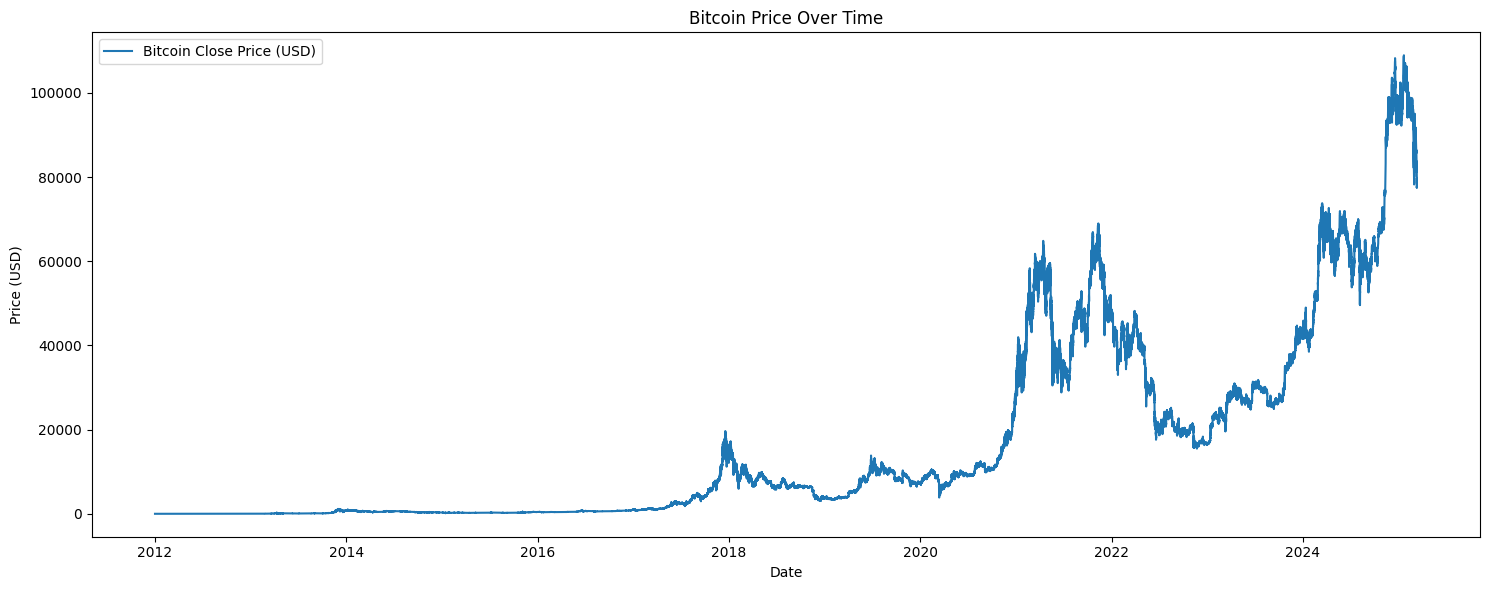

In [31]:
# Vẽ biểu đồ giá Bitcoin theo thời gian
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Giá đóng cửa của Bitcoin (USD)')
plt.title('Biến động giá Bitcoin theo thời gian')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()


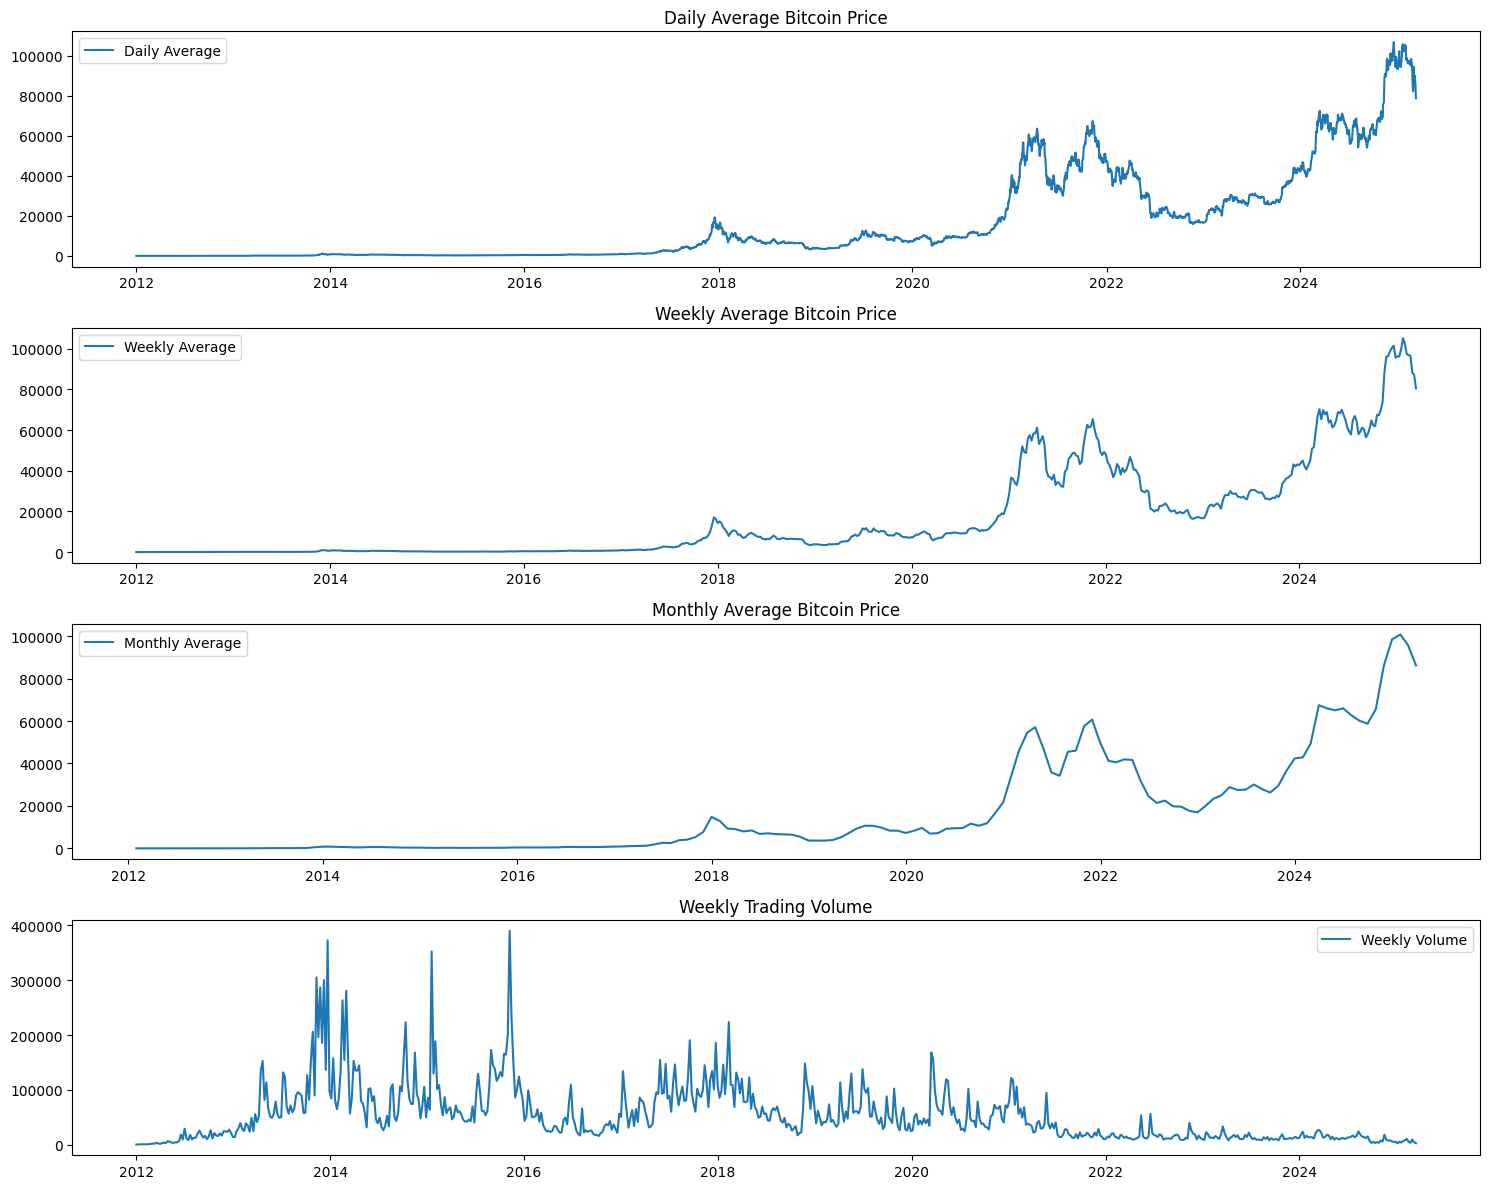

In [32]:
# Lấy mẫu lại dữ liệu để vẽ biểu đồ theo các khoảng thời gian khác nhau
plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
plt.plot(df['Close'].resample('D').mean(), label='Trung bình ngày')
plt.title('Giá Bitcoin trung bình theo ngày')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df['Close'].resample('W').mean(), label='Trung bình tuần')
plt.title('Giá Bitcoin trung bình theo tuần')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df['Close'].resample('M').mean(), label='Trung bình tháng')
plt.title('Giá Bitcoin trung bình theo tháng')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(df['Volume'].resample('W').sum(), label='Khối lượng giao dịch tuần')
plt.title('Khối lượng giao dịch Bitcoin theo tuần')
plt.legend()

plt.tight_layout()
plt.show()


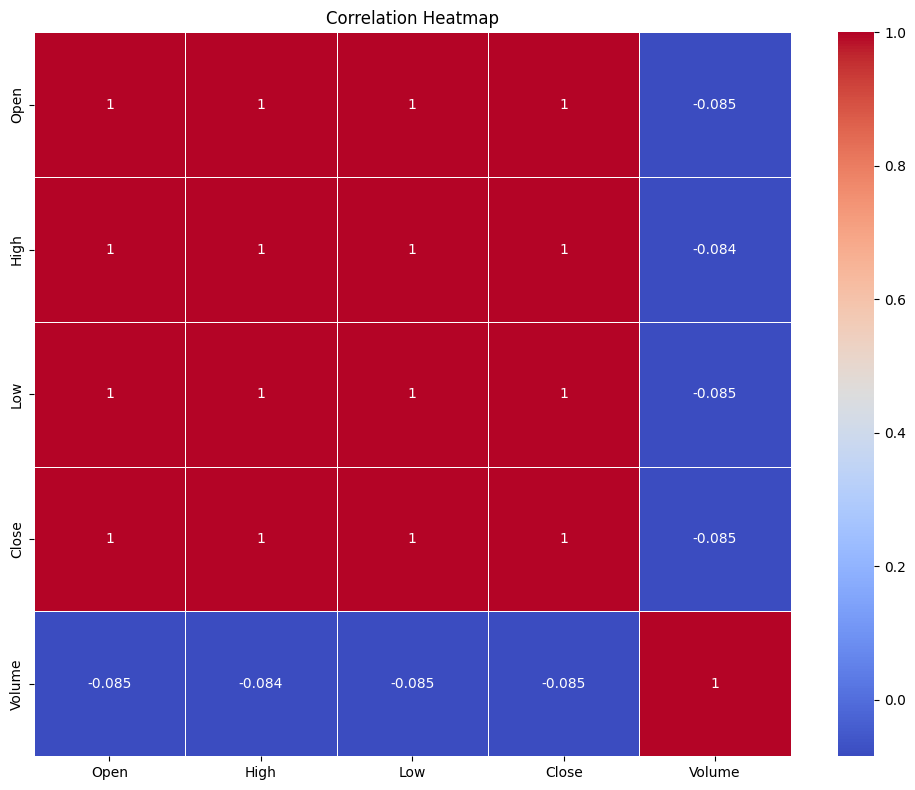

In [33]:
# Tạo bản đồ nhiệt hiển thị mối tương quan
plt.figure(figsize=(10, 8))
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Bản đồ nhiệt của ma trận tương quan')
plt.tight_layout()
plt.show()


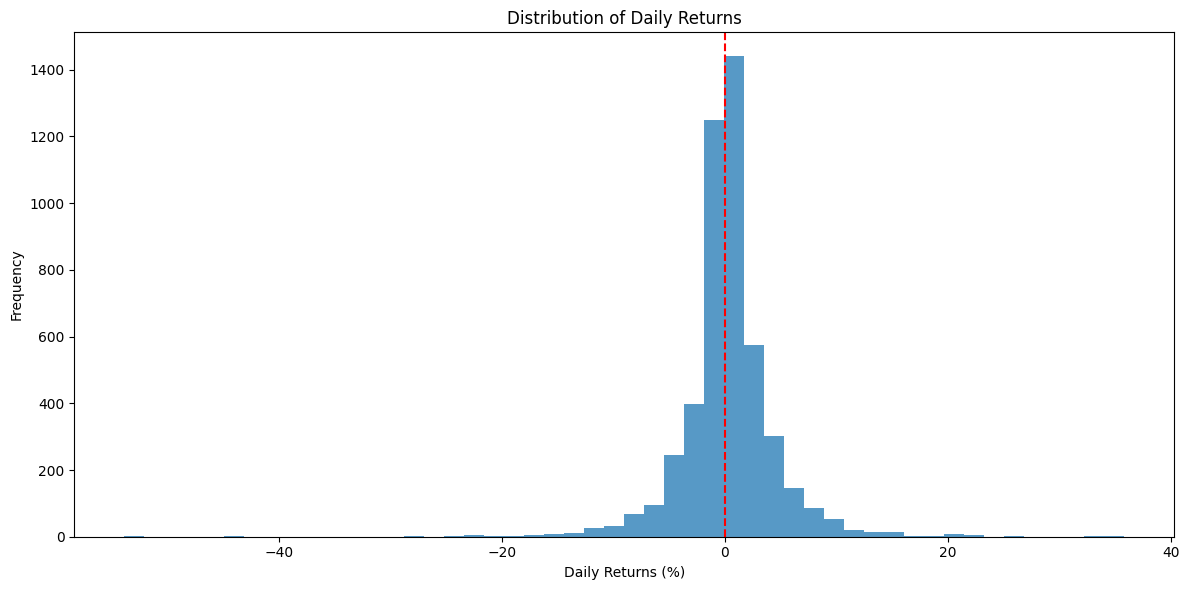

In [34]:
# Biểu đồ tần suất lợi nhuận hàng ngày
df_daily = df.resample('D').last()
df_daily['Returns'] = df_daily['Close'].pct_change() * 100

plt.figure(figsize=(12, 6))
plt.hist(df_daily['Returns'].dropna(), bins=50, alpha=0.75)
plt.title('Phân bố lợi nhuận hàng ngày')
plt.xlabel('Lợi nhuận hàng ngày (%)')
plt.ylabel('Tần suất')
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


## 4. Data Preprocessing

In [35]:
# Lấy mẫu lại dữ liệu theo ngày với phương pháp tổng hợp phù hợp
df_daily = df.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

print(f"\nKích thước dữ liệu sau khi tổng hợp theo ngày: {df_daily.shape}")



Shape of daily aggregated data: (4819, 5)


In [36]:
# Kỹ thuật tạo đặc trưng (Feature Engineering)
def add_technical_indicators(df):
    # Đường trung bình động (Moving Averages)
    df['MA7'] = df['Close'].rolling(window=7).mean()
    df['MA14'] = df['Close'].rolling(window=14).mean()
    df['MA30'] = df['Close'].rolling(window=30).mean()
    
    # Động lượng giá (Price Momentum)
    df['Price_Momentum'] = df['Close'] - df['Close'].shift(7)
    
    # Độ biến động (Volatility - độ lệch chuẩn của lợi nhuận)
    df['Volatility'] = df['Close'].pct_change().rolling(window=7).std() * 100
    
    # Tỷ lệ thay đổi giá (Rate of Change - ROC)
    df['ROC'] = ((df['Close'] - df['Close'].shift(7)) / df['Close'].shift(7)) * 100
    
    # Chỉ số sức mạnh tương đối (Relative Strength Index - RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Đường trung bình hội tụ phân kỳ (MACD)
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Biến mục tiêu cho mô hình phân loại
    df['Target_Next_Day'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
    df['Target_Next_Week'] = np.where(df['Close'].shift(-7) > df['Close'], 1, 0)
    
    return df

# Thêm các chỉ báo kỹ thuật
df_daily = add_technical_indicators(df_daily)

# Loại bỏ các giá trị NaN sau khi thêm chỉ báo kỹ thuật
df_daily.dropna(inplace=True)
print(f"\nKích thước dữ liệu sau khi thêm chỉ báo kỹ thuật và loại bỏ NaN: {df_daily.shape}")



Shape after adding technical indicators and dropping NaNs: (4790, 16)


In [37]:
# Hiển thị tập dữ liệu đã được mở rộng
print("\nXem trước tập dữ liệu sau khi bổ sung chỉ báo kỹ thuật:")
print(df_daily.head())



Enhanced Dataset Preview:
            Open  High   Low  Close      Volume       MA7      MA14      MA30  \
Timestamp                                                                       
2012-01-30  5.90  5.90  5.30   5.58   22.380000  5.870000  6.310714  6.340333   
2012-01-31  5.58  6.22  5.55   5.55  104.718333  5.727143  6.214286  6.364000   
2012-02-01  5.55  6.00  3.80   5.99   13.552446  5.725714  6.135000  6.397000   
2012-02-02  5.99  6.26  5.54   6.26  123.582638  5.724286  6.152857  6.429333   
2012-02-03  6.26  6.35  5.93   6.29  283.382106  5.782857  6.105714  6.453333   

            Price_Momentum  Volatility        ROC        RSI      MACD  \
Timestamp                                                                
2012-01-30           -0.94   11.684364 -14.417178  38.087774 -0.068881   
2012-01-31           -1.00   11.660670 -15.267176  39.130435 -0.104298   
2012-02-01           -0.01   11.747283  -0.166667  41.395349 -0.095758   
2012-02-02           -0.01   11.747

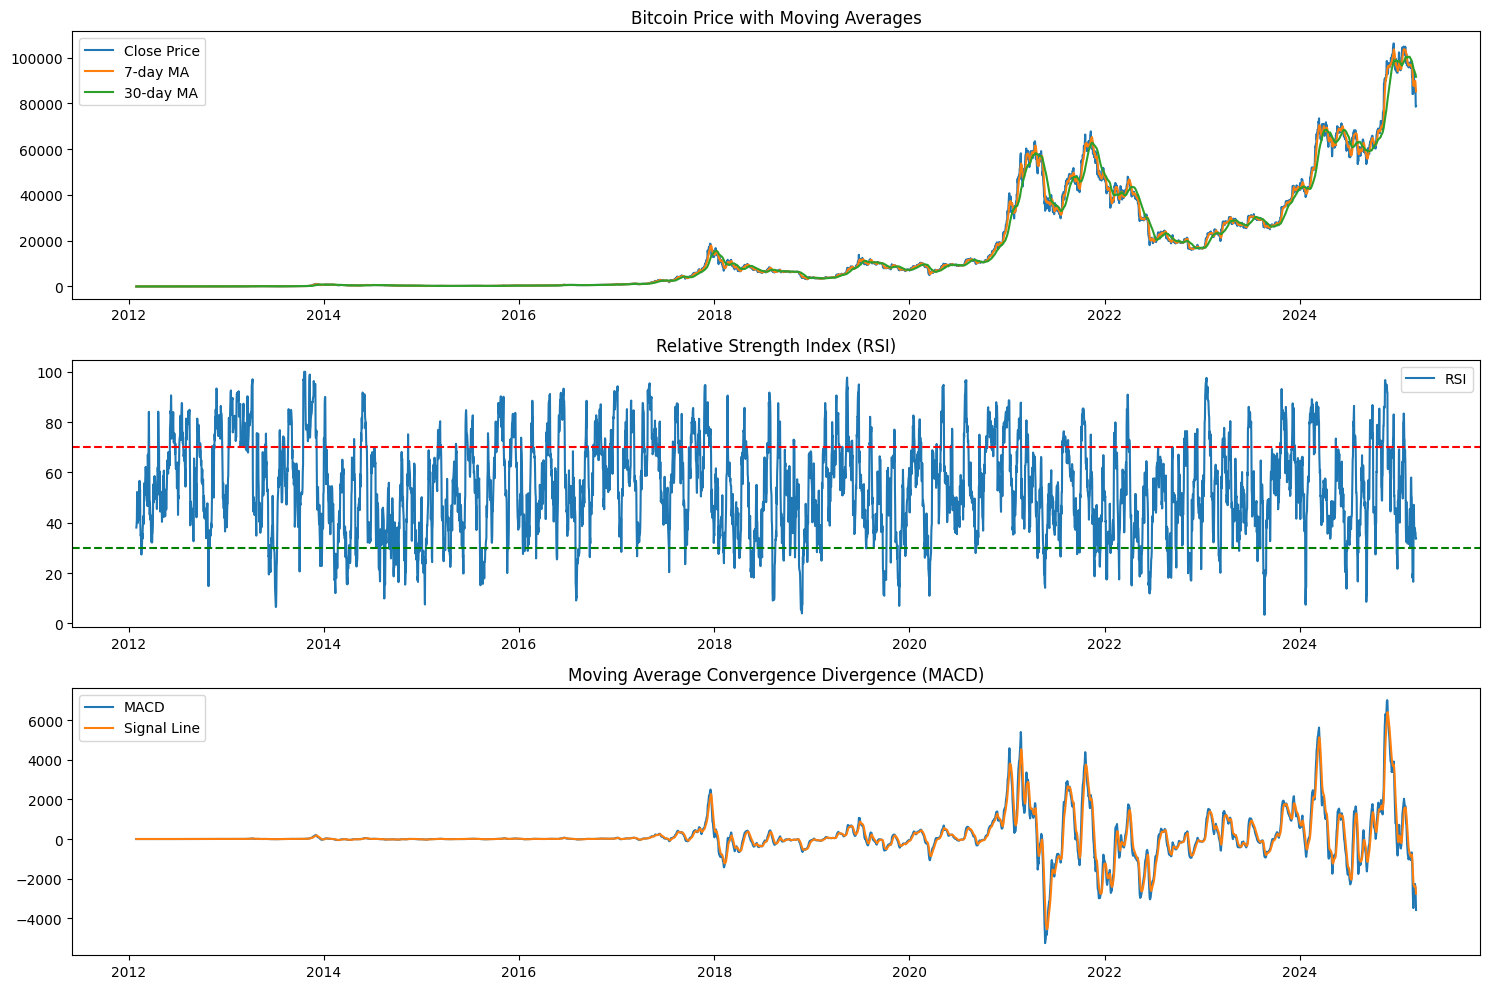

In [38]:
# Trực quan hóa một số chỉ báo kỹ thuật
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df_daily['Close'], label='Giá đóng cửa')
plt.plot(df_daily['MA7'], label='Đường trung bình 7 ngày')
plt.plot(df_daily['MA30'], label='Đường trung bình 30 ngày')
plt.title('Giá Bitcoin với đường trung bình động')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_daily['RSI'], label='RSI')
plt.axhline(y=70, color='r', linestyle='--')
plt.axhline(y=30, color='g', linestyle='--')
plt.title('Chỉ số sức mạnh tương đối (RSI)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df_daily['MACD'], label='MACD')
plt.plot(df_daily['MACD_Signal'], label='Đường tín hiệu')
plt.title('Đường trung bình hội tụ phân kỳ (MACD)')
plt.legend()

plt.tight_layout()
plt.show()


## 5. Preparing Data for Machine Learning

In [39]:
# Hàm tạo chuỗi dữ liệu cho dự báo chuỗi thời gian
def create_sequences(data, target_col, window_size):
    """Tạo chuỗi dữ liệu cho mô hình dự báo chuỗi thời gian"""
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i+window_size].values)
        y.append(data.iloc[i+window_size][target_col])
    return np.array(X), np.array(y)

# Hàm chuẩn bị dữ liệu cho mô hình hồi quy/phân loại
def prepare_data_for_ml(df, target_col, window_size=0, is_classification=False):
    """Chuẩn bị dữ liệu cho các mô hình máy học"""
    # Dành cho mô hình chuỗi thời gian (sử dụng window_size)
    if window_size > 0:
        X, y = create_sequences(df, target_col, window_size)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Dành cho các mô hình truyền thống
    else:
        # Chọn đặc trưng và biến mục tiêu
        X = df.drop(['Open', 'High', 'Low', 'Close', 'Target_Next_Day', 'Target_Next_Week'], axis=1) 
        if is_classification:
            y = df[target_col].astype(int)
        else:
            y = df['Close']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test


In [40]:
# Tách đặc trưng và biến mục tiêu cho mô hình hồi quy
X = df_daily.drop(['Open', 'High', 'Low', 'Close', 'Target_Next_Day', 'Target_Next_Week'], axis=1)
y_reg = df_daily['Close']

# Chuẩn hóa dữ liệu cho mô hình hồi quy
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_reg_scaled = scaler_y.fit_transform(y_reg.values.reshape(-1, 1)).flatten()

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_reg_scaled, test_size=0.2, random_state=42)

print(f"\nKích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")



Training set shape: (3832, 10)
Test set shape: (958, 10)


In [41]:
# Chuẩn bị dữ liệu cho mô hình phân loại
X_class = df_daily.drop(['Open', 'High', 'Low', 'Close', 'Target_Next_Day', 'Target_Next_Week'], axis=1)
y_class = df_daily['Target_Next_Day']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra cho mô hình phân loại
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)


In [42]:
# Dữ liệu cho mô hình chuỗi thời gian (LSTM)
time_steps = 30  # Số ngày quan sát trước đó
X_ts, y_ts = create_sequences(df_daily[['Close'] + list(X.columns)], 'Close', time_steps)

# Chuẩn hóa dữ liệu chuỗi thời gian
scaler_ts = MinMaxScaler()
X_ts_scaled = np.zeros_like(X_ts)
for i in range(X_ts.shape[0]):
    X_ts_scaled[i] = scaler_ts.fit_transform(X_ts[i])
y_ts_scaled = scaler_y.transform(y_ts.reshape(-1, 1)).flatten()

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
split_idx = int(0.8 * len(X_ts_scaled))
X_train_ts, X_test_ts = X_ts_scaled[:split_idx], X_ts_scaled[split_idx:]
y_train_ts, y_test_ts = y_ts_scaled[:split_idx], y_ts_scaled[split_idx:]

print(f"\nKích thước tập huấn luyện chuỗi thời gian: {X_train_ts.shape}")
print(f"Kích thước tập kiểm tra chuỗi thời gian: {X_test_ts.shape}")



Time series training set shape: (3808, 30, 11)
Time series test set shape: (952, 30, 11)


## 6. Model Development and Training

### 6.1 Linear Regression

In [43]:
# Huấn luyện mô hình hồi quy tuyến tính
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Dự đoán giá trị
y_pred_lr = lr_model.predict(X_test)

# Đánh giá mô hình
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print("\n=== Kết quả Hồi quy tuyến tính ===")
print(f"RMSE: {lr_rmse:.4f}")
print(f"MAE: {lr_mae:.4f}")
print(f"R^2: {lr_r2:.4f}")



=== Linear Regression Results ===
RMSE: 0.0044
MAE: 0.0022
R^2: 0.9996


### A. Regression Models

In [44]:
def train_and_evaluate_regression_models(X_train, X_test, y_train, y_test):
    """Huấn luyện và đánh giá nhiều mô hình hồi quy"""
    results = {}
    
    # Hồi quy cây quyết định (Decision Tree Regressor)
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train, y_train)
    y_pred_dt = dt_model.predict(X_test)
    results['Decision Tree'] = {
        'model': dt_model,
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred_dt)),
        'mae': mean_absolute_error(y_test, y_pred_dt),
        'r2': r2_score(y_test, y_pred_dt)
    }
    
    # Hồi quy rừng ngẫu nhiên (Random Forest Regressor)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    results['Random Forest'] = {
        'model': rf_model,
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        'mae': mean_absolute_error(y_test, y_pred_rf),
        'r2': r2_score(y_test, y_pred_rf)
    }
    
    # Hồi quy vector hỗ trợ (Support Vector Regression - SVR)
    svr_model = SVR(kernel='rbf')
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    results['SVR'] = {
        'model': svr_model,
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred_svr)),
        'mae': mean_absolute_error(y_test, y_pred_svr),
        'r2': r2_score(y_test, y_pred_svr)
    }
    
    # Hồi quy K-Nearest Neighbors (KNN Regressor)
    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    results['KNN'] = {
        'model': knn_model,
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred_knn)),
        'mae': mean_absolute_error(y_test, y_pred_knn),
        'r2': r2_score(y_test, y_pred_knn)
    }
    
    return results

# Huấn luyện và đánh giá các mô hình hồi quy
regression_results = train_and_evaluate_regression_models(X_train, X_test, y_train, y_test)

# Hiển thị kết quả của các mô hình hồi quy
print("\n=== Kết quả các mô hình hồi quy ===")
for model_name, result in regression_results.items():
    print(f"\nKết quả {model_name}:")
    print(f"RMSE: {result['rmse']:.4f}")
    print(f"MAE: {result['mae']:.4f}")
    print(f"R^2: {result['r2']:.4f}")



=== Regression Model Results ===

Decision Tree Results:
RMSE: 0.0088
MAE: 0.0039
R^2: 0.9985

Random Forest Results:
RMSE: 0.0063
MAE: 0.0029
R^2: 0.9992

SVR Results:
RMSE: 0.0445
MAE: 0.0382
R^2: 0.9610

KNN Results:
RMSE: 0.0094
MAE: 0.0058
R^2: 0.9982


### B. Classification Models

In [45]:
def train_and_evaluate_classification_models(X_train, X_test, y_train, y_test):
    """Huấn luyện và đánh giá nhiều mô hình phân loại"""
    results = {}

    # Cây quyết định (Decision Tree Classifier)
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)
    y_pred_dt = dt_model.predict(X_test)
    results['Cây quyết định'] = {
        'model': dt_model,
        'độ chính xác': accuracy_score(y_test, y_pred_dt),
        'độ chính xác (precision)': precision_score(y_test, y_pred_dt),
        'độ nhạy (recall)': recall_score(y_test, y_pred_dt),
        'F1 Score': f1_score(y_test, y_pred_dt)
    }

    # Rừng ngẫu nhiên (Random Forest Classifier)
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    results['Rừng ngẫu nhiên'] = {
        'model': rf_model,
        'độ chính xác': accuracy_score(y_test, y_pred_rf),
        'độ chính xác (precision)': precision_score(y_test, y_pred_rf),
        'độ nhạy (recall)': recall_score(y_test, y_pred_rf),
        'F1 Score': f1_score(y_test, y_pred_rf)
    }

    # Máy vector hỗ trợ (Support Vector Machine Classifier)
    svc_model = SVC(kernel='rbf', probability=True)
    svc_model.fit(X_train, y_train)
    y_pred_svc = svc_model.predict(X_test)
    results['SVC'] = {
        'model': svc_model,
        'độ chính xác': accuracy_score(y_test, y_pred_svc),
        'độ chính xác (precision)': precision_score(y_test, y_pred_svc),
        'độ nhạy (recall)': recall_score(y_test, y_pred_svc),
        'F1 Score': f1_score(y_test, y_pred_svc)
    }

    # K-láng giềng gần nhất (K-Nearest Neighbors Classifier)
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    results['KNN'] = {
        'model': knn_model,
        'độ chính xác': accuracy_score(y_test, y_pred_knn),
        'độ chính xác (precision)': precision_score(y_test, y_pred_knn),
        'độ nhạy (recall)': recall_score(y_test, y_pred_knn),
        'F1 Score': f1_score(y_test, y_pred_knn)
    }

    return results

# Huấn luyện và đánh giá các mô hình phân loại
classification_results = train_and_evaluate_classification_models(X_train_class, X_test_class, y_train_class, y_test_class)

# Hiển thị kết quả phân loại
print("\n=== Kết quả mô hình phân loại (Dự đoán xu hướng giá) ===")
for model_name, result in classification_results.items():
    print(f"\nKết quả của {model_name}:")
    print(f"Độ chính xác: {result['độ chính xác']:.4f}")
    print(f"Độ chính xác (Precision): {result['độ chính xác (precision)']:.4f}")
    print(f"Độ nhạy (Recall): {result['độ nhạy (recall)']:.4f}")
    print(f"F1 Score: {result['F1 Score']:.4f}")



=== Classification Model Results (Price Direction Prediction) ===

Decision Tree Results:
Accuracy: 0.4979
Precision: 0.5344
Recall: 0.5416
F1 Score: 0.5379

Random Forest Results:
Accuracy: 0.4896
Precision: 0.5258
Recall: 0.5513
F1 Score: 0.5382

SVC Results:
Accuracy: 0.5365
Precision: 0.5392
Recall: 0.9710
F1 Score: 0.6934

KNN Results:
Accuracy: 0.4937
Precision: 0.5307
Recall: 0.5358
F1 Score: 0.5332


### C. Time Series Models (LSTM)

In [46]:
# Định dạng lại dữ liệu đầu vào cho LSTM [mẫu, bước thời gian, đặc trưng]
n_features = X_train_ts.shape[2]
X_train_ts_reshaped = X_train_ts.reshape(X_train_ts.shape[0], time_steps, n_features)
X_test_ts_reshaped = X_test_ts.reshape(X_test_ts.shape[0], time_steps, n_features)

# Định nghĩa mô hình LSTM
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Tạo và huấn luyện mô hình LSTM
lstm_model = create_lstm_model((time_steps, n_features))
print("\nTóm tắt mô hình LSTM:")
lstm_model.summary()



LSTM Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 30, 50)              │          12,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,901 (132.43 KB)

 Trainable params: 33,901 (132.43 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Định nghĩa các callback cho quá trình huấn luyện
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Huấn luyện mô hình LSTM
lstm_history = lstm_model.fit(
    X_train_ts_reshaped, y_train_ts,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
)


Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0121 - val_loss: 0.1181 - learning_rate: 0.0010
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0018 - val_loss: 0.1181 - learning_rate: 0.0010
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0016 - val_loss: 0.1213 - learning_rate: 0.0010
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0015 - val_loss: 0.1212 - learning_rate: 0.0010
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0014 - val_loss: 0.1190 - learning_rate: 0.0010
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0013 - val_loss: 0.1120 - learning_rate: 0.0010
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0014 - val_loss: 0.1185 - learning_rate: 0.0010
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0013 - val_loss: 0.1174 - learning_rate: 0.0010
Epoch 9/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0012 - val_loss: 0.1143 - learning_rate: 0.0010
Epoch 10/1

In [48]:
# Đánh giá mô hình LSTM
lstm_test_loss = lstm_model.evaluate(X_test_ts_reshaped, y_test_ts, verbose=0)
lstm_predictions = lstm_model.predict(X_test_ts_reshaped)

# Chuyển đổi dự đoán về thang đo ban đầu
lstm_predictions = scaler_y.inverse_transform(lstm_predictions)
y_test_original = scaler_y.inverse_transform(y_test_ts.reshape(-1, 1))

# Tính toán các chỉ số đánh giá hiệu suất
lstm_rmse = np.sqrt(mean_squared_error(y_test_original, lstm_predictions))
lstm_mae = mean_absolute_error(y_test_original, lstm_predictions)
lstm_r2 = r2_score(y_test_original, lstm_predictions)

print("\n=== Kết quả mô hình LSTM ===")
print(f"Độ mất mát trên tập kiểm tra: {lstm_test_loss:.4f}")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"MAE: {lstm_mae:.4f}")
print(f"R^2: {lstm_r2:.4f}")


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

=== LSTM Model Results ===
Test Loss: 0.2201
RMSE: 49811.0630
MAE: 42730.3744
R^2: -2.7410


## 7. Model Evaluation and Comparison

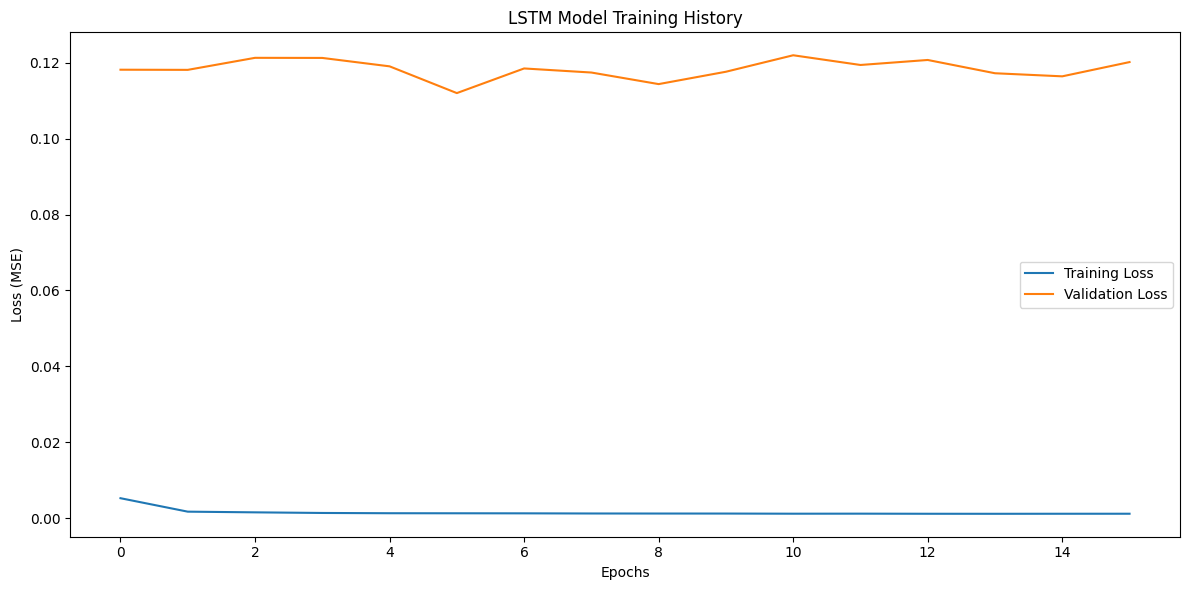

In [49]:
# Vẽ biểu đồ lịch sử huấn luyện của mô hình LSTM
plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['loss'], label='Mất mát trên tập huấn luyện')
plt.plot(lstm_history.history['val_loss'], label='Mất mát trên tập kiểm định')
plt.title('Lịch sử huấn luyện mô hình LSTM')
plt.xlabel('Số epoch')
plt.ylabel('Mất mát (MSE)')
plt.legend()
plt.tight_layout()
plt.show()


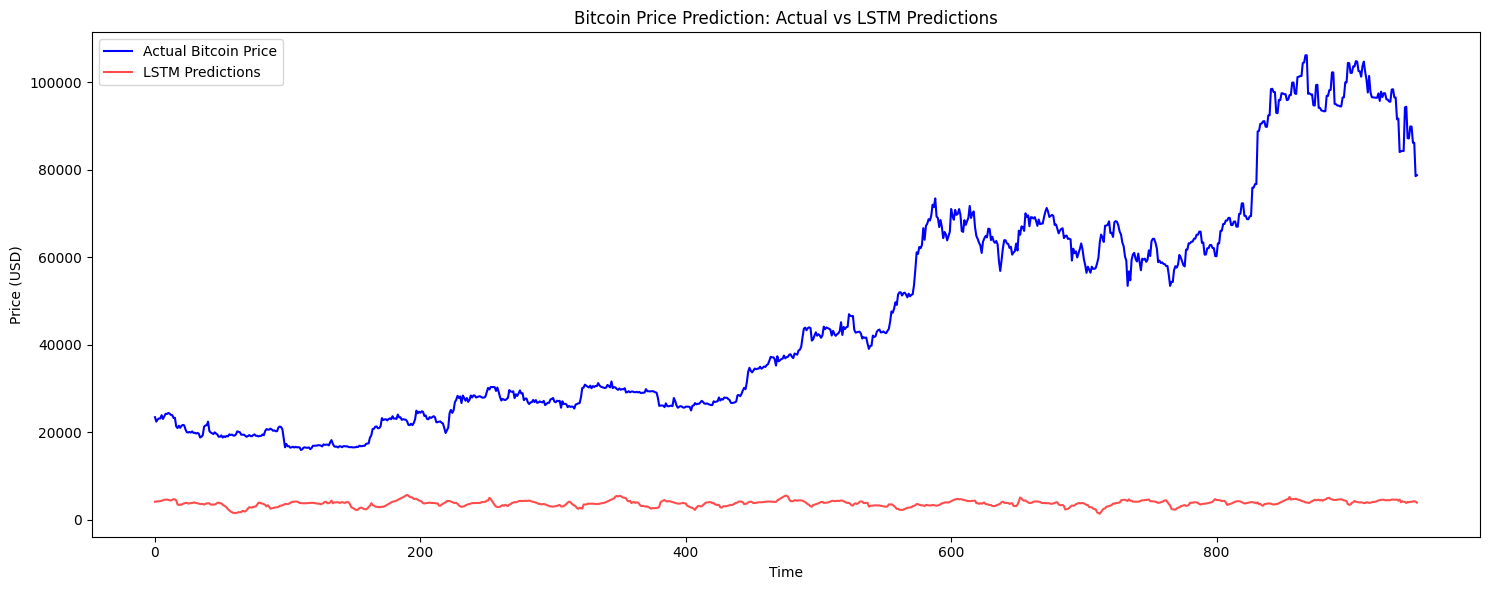

In [50]:
# Vẽ biểu đồ so sánh giữa giá thực tế và dự đoán của mô hình LSTM
plt.figure(figsize=(15, 6))
plt.plot(y_test_original, label='Giá Bitcoin thực tế', color='blue')
plt.plot(lstm_predictions, label='Dự đoán của LSTM', color='red', alpha=0.7)
plt.title('Dự đoán giá Bitcoin: Thực tế vs Dự đoán LSTM')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.tight_layout()
plt.show()


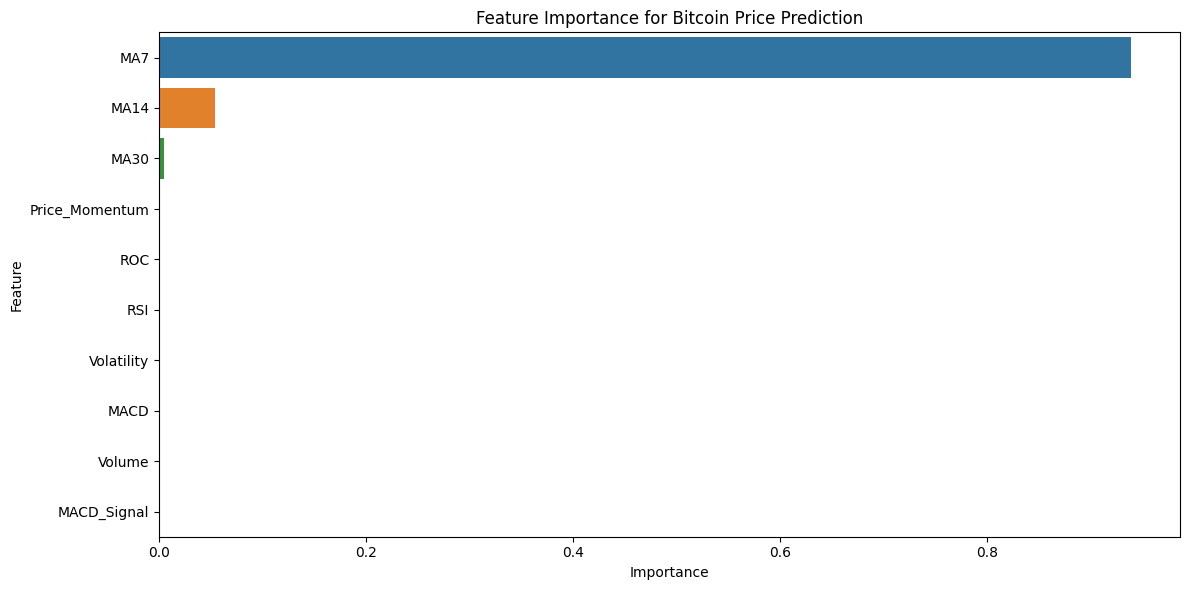

In [51]:
# Lấy mô hình hồi quy có hiệu suất tốt nhất
best_reg_model_name = min(regression_results, key=lambda k: regression_results[k]['rmse'])
best_reg_model = regression_results[best_reg_model_name]['model']

# Lấy tầm quan trọng của đặc trưng nếu mô hình tốt nhất là Random Forest
if best_reg_model_name == 'Random Forest':
    feature_importances = best_reg_model.feature_importances_
    feature_names = X.columns
    
    # Tạo DataFrame chứa tầm quan trọng của đặc trưng và sắp xếp
    importance_df = pd.DataFrame({
        'Đặc trưng': feature_names,
        'Tầm quan trọng': feature_importances
    })
    importance_df = importance_df.sort_values('Tầm quan trọng', ascending=False)
    
    # Vẽ biểu đồ tầm quan trọng của đặc trưng
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Tầm quan trọng', y='Đặc trưng', data=importance_df)
    plt.title('Tầm quan trọng của đặc trưng trong dự đoán giá Bitcoin')
    plt.tight_layout()
    plt.show()


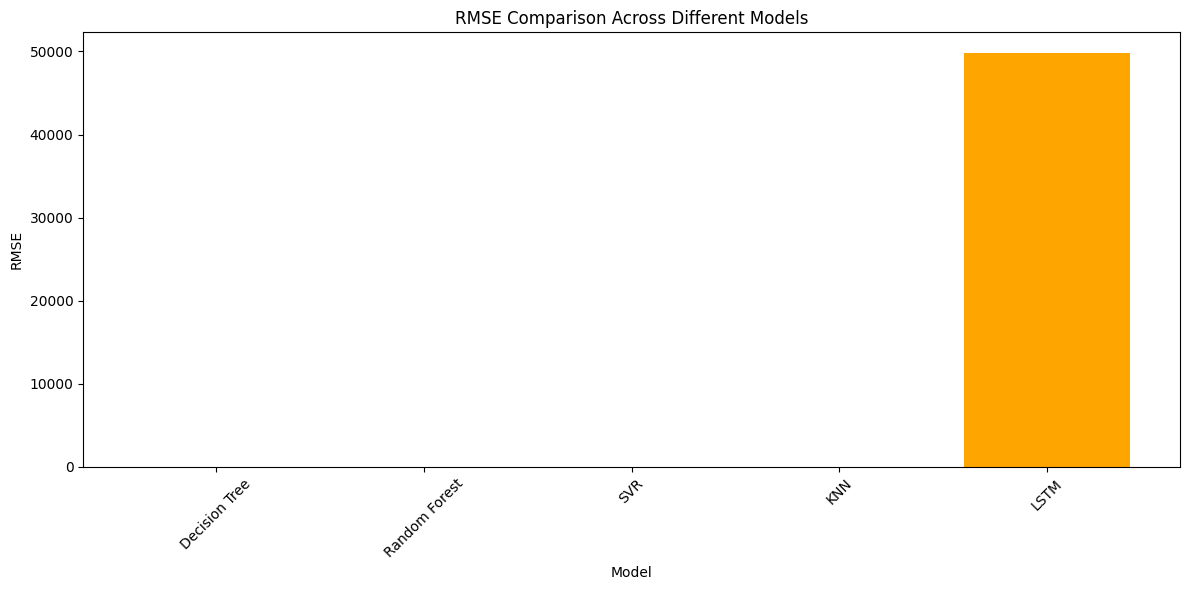

In [52]:
# So sánh hiệu suất của tất cả các mô hình hồi quy
plt.figure(figsize=(12, 6))
models = list(regression_results.keys()) + ['LSTM']
rmse_values = [regression_results[model]['rmse'] for model in regression_results] + [lstm_rmse]
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Màu sắc cho từng mô hình

plt.bar(models, rmse_values, color=colors)
plt.title('So sánh RMSE giữa các mô hình')
plt.xlabel('Mô hình')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

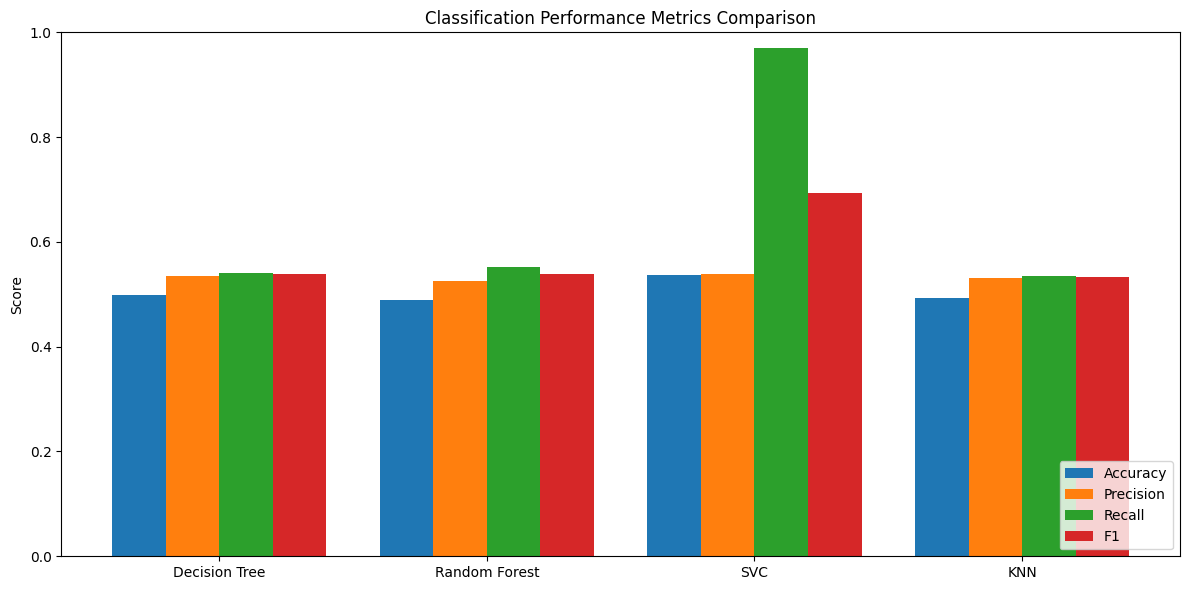

In [53]:
# So sánh hiệu suất của các mô hình phân loại
plt.figure(figsize=(12, 6))
classifiers = list(classification_results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_values = {
    metric: [classification_results[model][metric] for model in classifiers]
    for metric in metrics
}

x = np.arange(len(classifiers))  # Tạo chỉ số cho trục x
width = 0.2  # Độ rộng của mỗi cột
multiplier = 0  # Hệ số dịch chuyển

fig, ax = plt.subplots(figsize=(12, 6))

# Duyệt qua từng metric và vẽ biểu đồ cột
for metric, values in metric_values.items():
    offset = width * multiplier
    ax.bar(x + offset, values, width, label=metric.capitalize())
    multiplier += 1

ax.set_title('So sánh các chỉ số hiệu suất mô hình phân loại')
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(classifiers)
ax.set_ylim(0, 1)
ax.set_ylabel('Điểm số')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()


## 8. Model Optimization with Cross-Validation

In [ ]:
# Định nghĩa hàm thực hiện k-fold cross-validation
def perform_kfold_cv(model, X, y, k=5):
    """Thực hiện k-fold cross-validation"""
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
    
    return rmse_scores

# Thực hiện cross-validation cho mô hình hồi quy tốt nhất
if best_reg_model_name == 'Random Forest':
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_cv_scores = perform_kfold_cv(rf_model, X_scaled, y_reg_scaled)
    
    print(f"\nKết quả 5-Fold CV của Random Forest:")
    print(f"RMSE trên các lần chạy: {rf_cv_scores}")
    print(f"RMSE trung bình: {np.mean(rf_cv_scores):.4f}")
    print(f"Độ lệch chuẩn RMSE: {np.std(rf_cv_scores):.4f}")
    
    # Tinh chỉnh siêu tham số bằng GridSearchCV
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_scaled, y_reg_scaled)
    
    print("\nSiêu tham số tối ưu cho Random Forest:")
    print(grid_search.best_params_)
    
    # Huấn luyện mô hình tối ưu
    best_rf_model = grid_search.best_estimator_
    best_rf_model.fit(X_train, y_train)
    y_pred_best_rf = best_rf_model.predict(X_test)
    
    # Đánh giá mô hình tối ưu
    best_rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
    best_rf_mae = mean_absolute_error(y_test, y_pred_best_rf)
    best_rf_r2 = r2_score(y_test, y_pred_best_rf)
    
    print("\nKết quả mô hình Random Forest tối ưu:")
    print(f"RMSE: {best_rf_rmse:.4f}")
    print(f"MAE: {best_rf_mae:.4f}")
    print(f"R^2: {best_rf_r2:.4f}")



Random Forest 5-Fold CV Results:
RMSE Scores: [0.006309737914789226, 0.00535408971896403, 0.006303715249541103, 0.006135274822871047, 0.007034414500747338]
Mean RMSE: 0.0062
Std Dev RMSE: 0.0005


## 9. Predicting Future Bitcoin Prices

In [ ]:
# Sử dụng mô hình tốt nhất để dự đoán giá tương lai
best_model = best_rf_model if best_reg_model_name == 'Random Forest' else best_reg_model

# Hàm dự đoán giá cho ngày tiếp theo
def predict_next_day_price(model, last_data, scaler_x, scaler_y):
    """Dự đoán giá Bitcoin cho ngày tiếp theo sử dụng mô hình đã huấn luyện"""
    # Chuẩn hóa dữ liệu đầu vào
    last_data_scaled = scaler_x.transform(last_data.reshape(1, -1))
    
    # Dự đoán giá
    prediction_scaled = model.predict(last_data_scaled)
    
    # Chuyển đổi về thang đo thực tế
    prediction = scaler_y.inverse_transform(prediction_scaled.reshape(-1, 1))
    
    return prediction[0][0]

# Lấy điểm dữ liệu cuối cùng có sẵn
last_data = X_scaled[-1]

# Dự đoán giá cho ngày tiếp theo
next_day_price = predict_next_day_price(best_model, last_data, scaler_X, scaler_y)
print(f"\nDự đoán giá Bitcoin cho ngày tiếp theo: ${next_day_price:.2f}")


In [ ]:
# Dự đoán giá tương lai với mô hình LSTM
def predict_next_day_lstm(model, last_sequence, scaler):
    """Dự đoán giá Bitcoin cho ngày tiếp theo sử dụng mô hình LSTM"""
    # Định dạng lại dữ liệu đầu vào cho LSTM
    last_sequence_reshaped = last_sequence.reshape(1, time_steps, n_features)
    
    # Thực hiện dự đoán
    prediction_scaled = model.predict(last_sequence_reshaped)
    
    # Chuyển đổi về thang đo thực tế
    prediction = scaler.inverse_transform(prediction_scaled)
    
    return prediction[0][0]

# Lấy chuỗi dữ liệu cuối cùng để dự đoán với LSTM
last_sequence = X_test_ts_reshaped[-1]

# Dự đoán giá cho ngày tiếp theo bằng LSTM
next_day_price_lstm = predict_next_day_lstm(lstm_model, last_sequence, scaler_y)
print(f"Dự đoán giá Bitcoin cho ngày tiếp theo (LSTM): ${next_day_price_lstm:.2f}")


## 10. Multi-day Price Forecasting

In [ ]:
# Hàm dự đoán giá Bitcoin cho nhiều ngày tiếp theo
def forecast_future_prices(model, last_data, days=7, is_lstm=False):
    """Dự đoán giá Bitcoin trong một số ngày tới"""
    forecasted_prices = []
    current_data = last_data.copy()
    
    for _ in range(days):
        if is_lstm:
            # Định dạng dữ liệu cho LSTM
            current_data_reshaped = current_data.reshape(1, time_steps, n_features)
            # Thực hiện dự đoán
            next_price = model.predict(current_data_reshaped)[0][0]
            # Cập nhật chuỗi dữ liệu bằng cách loại bỏ giá trị đầu tiên và thêm dự đoán mới
            current_data = np.roll(current_data, -1, axis=0)
            current_data[-1, 0] = next_price  # Giả sử giá 'Close' nằm ở index 0
        else:
            # Đối với mô hình ML truyền thống
            next_price = model.predict(current_data.reshape(1, -1))[0]
            
        forecasted_prices.append(next_price)
    
    return forecasted_prices

# Lựa chọn mô hình tốt nhất dựa trên đánh giá
if lstm_rmse < best_rf_rmse:
    best_overall_model = lstm_model
    last_data_for_forecast = last_sequence
    is_lstm = True
    print("\nLSTM là mô hình có hiệu suất tốt nhất.")
else:
    best_overall_model = best_model
    last_data_for_forecast = last_data
    is_lstm = False
    print(f"\n{best_reg_model_name} là mô hình có hiệu suất tốt nhất.")

# Dự đoán giá cho 7 ngày tiếp theo
forecast_days = 7
future_prices = forecast_future_prices(best_overall_model, last_data_for_forecast, forecast_days, is_lstm)

# Chuyển đổi dữ liệu về giá trị thực nếu mô hình không phải LSTM
if not is_lstm:
    future_prices = scaler_y.inverse_transform(np.array(future_prices).reshape(-1, 1)).flatten()

# Tạo dãy ngày cho dự báo
last_date = df_daily.index[-1]
future_dates = [last_date + dt.timedelta(days=i+1) for i in range(forecast_days)]

# Hiển thị kết quả dự báo
print(f"\nDự đoán giá Bitcoin trong {forecast_days} ngày tới:")
for date, price in zip(future_dates, future_prices):
    print(f"{date.date()}: ${price:.2f}")


In [ ]:
# Vẽ biểu đồ kết quả chiến lược giao dịch
plt.figure(figsize=(12, 6))

# Vẽ giá thực tế
plt.plot(actual_prices, label="Giá thực tế", color='blue', alpha=0.6)

# Đánh dấu các điểm mua
buy_signals = [i for i in range(len(y_pred)) if y_pred[i] == 1]
buy_prices = [actual_prices[i] for i in buy_signals]
plt.scatter(buy_signals, buy_prices, marker="^", color="green", label="Mua", alpha=1)

# Đánh dấu các điểm bán
sell_signals = [i for i in range(len(y_pred)) if y_pred[i] == 0]
sell_prices = [actual_prices[i] for i in sell_signals]
plt.scatter(sell_signals, sell_prices, marker="v", color="red", label="Bán", alpha=1)

plt.title("Chiến lược giao dịch dựa trên mô hình phân loại")
plt.xlabel("Thời gian")
plt.ylabel("Giá Bitcoin (USD)")
plt.legend()
plt.tight_layout()
plt.show()


## 11. Trading Strategy Based on Price Direction Prediction

In [ ]:
# Lấy mô hình phân loại tốt nhất
best_class_model_name = max(classification_results, key=lambda k: classification_results[k]['accuracy'])
best_class_model = classification_results[best_class_model_name]['model']

print(f"\nMô hình phân loại tốt nhất: {best_class_model_name}")
print(f"Độ chính xác: {classification_results[best_class_model_name]['accuracy']:.4f}")

# Định nghĩa một chiến lược giao dịch đơn giản
def backtest_trading_strategy(model, X_test, y_test, vốn_ban_đầu=10000):
    """Backtest một chiến lược giao dịch đơn giản sử dụng mô hình phân loại"""
    vốn = vốn_ban_đầu
    lượng_btc = 0
    nhật_ký_giao_dịch = []
    
    # Dự đoán
    y_pred = model.predict(X_test)
    
    # Lấy giá thực tế (chuyển y_test về thang đo gốc)
    giá_thực_tế = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    for i in range(len(y_pred) - 1):
        giá_hiện_tại = giá_thực_tế[i]
        giá_ngày_sau = giá_thực_tế[i + 1]
        
        # Chiến lược: Mua nếu dự đoán giá sẽ tăng, bán nếu dự đoán giá sẽ giảm
        if y_pred[i] == 1 and lượng_btc == 0:  # Dự đoán giá tăng & chưa có BTC
            # Mua Bitcoin
            btc_mua = vốn / giá_hiện_tại
            lượng_btc = btc_mua
            vốn = 0
            nhật_ký_giao_dịch.append(f"Ngày {i}: Mua {btc_mua:.6f} BTC với giá ${giá_hiện_tại:.2f}")
        elif y_pred[i] == 0 and lượng_btc > 0:  # Dự đoán giá giảm & đang giữ BTC
            # Bán Bitcoin
            vốn = lượng_btc * giá_hiện_tại
            nhật_ký_giao_dịch.append(f"Ngày {i}: Bán {lượng_btc:.6f} BTC với giá ${giá_hiện_tại:.2f}, Vốn: ${vốn:.2f}")
            lượng_btc = 0
    
    # Đánh giá cuối cùng
    if lượng_btc > 0:
        vốn_cuối = lượng_btc * giá_thực_tế[-1]
        nhật_ký_giao_dịch.append(f"Cuối cùng: Chuyển {lượng_btc:.6f} BTC thành ${vốn_cuối:.2f}")
    else:
        vốn_cuối = vốn
    
    lợi_nhuận = vốn_cuối - vốn_ban_đầu
    phần_trăm_lợi_nhuận = (lợi_nhuận / vốn_ban_đầu) * 100
    
    return {
        'vốn_ban_đầu': vốn_ban_đầu,
        'vốn_cuối': vốn_cuối,
        'lợi_nhuận': lợi_nhuận,
        'phần_trăm_lợi_nhuận': phần_trăm_lợi_nhuận,
        'nhật_ký_giao_dịch': nhật_ký_giao_dịch
    }

# Chạy backtest cho chiến lược giao dịch
kết_quả_chiến_lược = backtest_trading_strategy(best_class_model, X_test_class, y_test, 10000)

print("\n=== Kết quả Backtest Chiến lược Giao dịch ===")
print(f"Vốn ban đầu: ${kết_quả_chiến_lược['vốn_ban_đầu']:.2f}")
print(f"Vốn cuối: ${kết_quả_chiến_lược['vốn_cuối']:.2f}")
print(f"Lợi nhuận: ${kết_quả_chiến_lược['lợi_nhuận']:.2f} ({kết_quả_chiến_lược['phần_trăm_lợi_nhuận']:.2f}%)")

print("\nNhật ký giao dịch (5 giao dịch đầu và 5 giao dịch cuối):")
for log in kết_quả_chiến_lược['nhật_ký_giao_dịch'][:5]:
    print(log)
print("...")
for log in kết_quả_chiến_lược['nhật_ký_giao_dịch'][-5:]:
    print(log)


## 12. Conclusion and Future Improvements

In [ ]:
print("\n=== Kết luận ===")
print("Trong dự án này, chúng tôi đã xây dựng và đánh giá thành công nhiều mô hình học máy để dự đoán giá Bitcoin.")

# Hiển thị mô hình tốt nhất cho các nhiệm vụ khác nhau
print("\nMô hình tốt nhất cho từng nhiệm vụ dự đoán:")
print(f"1. Hồi quy giá: {best_reg_model_name if lstm_rmse > best_rf_rmse else 'LSTM'}")
print(f"2. Phân loại xu hướng giá: {best_class_model_name}")

print("\nNhững phát hiện chính:")
print("1. Các chỉ báo kỹ thuật cung cấp đặc trưng giá trị trong dự đoán giá Bitcoin")
print("2. Mô hình chuỗi thời gian như LSTM có thể nắm bắt sự phụ thuộc theo thời gian của giá Bitcoin")
print("3. Tính biến động cao của thị trường tiền mã hóa khiến việc dự đoán chính xác trở nên khó khăn")
print(f"4. Chiến lược giao dịch của chúng tôi dựa trên {best_class_model_name} cho thấy kết quả {'đầy hứa hẹn' if strategy_results['profit_loss'] > 0 else 'hạn chế'}")

print("\nCải tiến trong tương lai:")
print("1. Tích hợp phân tích cảm xúc từ mạng xã hội và tin tức")
print("2. Bổ sung các chỉ số kinh tế vĩ mô và dữ liệu thị trường")
print("3. Thử nghiệm với các kiến trúc học sâu tiên tiến hơn")
print("4. Phát triển các chiến lược giao dịch tinh vi hơn")
print("5. Triển khai học trực tuyến để thích ứng với điều kiện thị trường thay đổi")



=== Conclusion ===
In this project, we've successfully built and evaluated various machine learning models for Bitcoin price prediction.

Best Models for Different Prediction Tasks:


NameError: name 'lstm_rmse' is not defined

In [1]:
# Biểu đồ cuối cùng hiển thị dự đoán so với giá thực tế
plt.figure(figsize=(15, 8))

# Tạo dãy ngày để trực quan hóa dữ liệu kiểm tra
ngày_kiểm_tra = df_daily.index[-len(y_test):]

# Vẽ giá thực tế
giá_thực_tế = scaler_y.inverse_transform(y_test.reshape(-1, 1))
plt.plot(ngày_kiểm_tra, giá_thực_tế, label='Giá thực tế', color='blue')

# Vẽ dự đoán từ LSTM
plt.plot(ngày_kiểm_tra, lstm_predictions[:len(ngày_kiểm_tra)], label='Dự đoán LSTM', color='red', alpha=0.7)

# Vẽ dự đoán từ mô hình hồi quy tốt nhất
dự_đoán_hồi_quy = best_model.predict(X_test)
dự_đoán_hồi_quy = scaler_y.inverse_transform(dự_đoán_hồi_quy.reshape(-1, 1))
plt.plot(ngày_kiểm_tra, dự_đoán_hồi_quy[:len(ngày_kiểm_tra)], label=f'Dự đoán {best_reg_model_name}', color='green', alpha=0.7)

# Vẽ giá dự báo trong tương lai
plt.plot(future_dates, future_prices, 'o-', label='Dự báo tương lai', color='purple')

plt.title('Tóm tắt dự đoán giá Bitcoin')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nCảm ơn bạn đã cùng chúng tôi khám phá dự đoán giá Bitcoin!")


NameError: name 'plt' is not defined